In [1]:
import numpy as np
import scipy.stats 
import pylab as plt

In [2]:
from astroML.datasets import fetch_dr7_quasar

# Fetch the quasar data
data = fetch_dr7_quasar()

# select the first 10000 points
data = data[:10000]

z = data['redshift']

## Rejection sampling

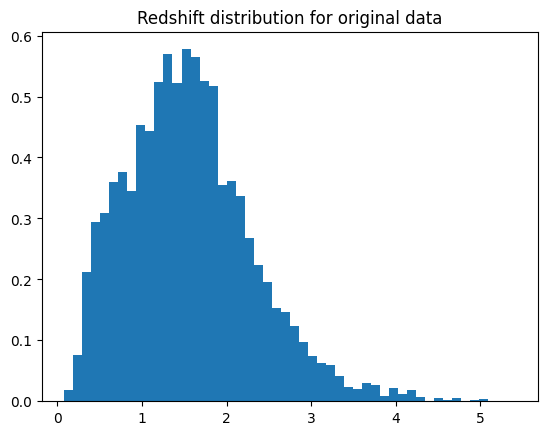

In [3]:
# Normalize the hist to have a pdf
nbin = 50
plt.hist(z, nbin, density=True)
plt.title('Redshift distribution for original data')
plt.show()

Now I create an np.histogram with the same data, in order to capture the info of the distribution

In [4]:
y, x = np.histogram(z, bins=nbin, density=True)
# x = bin extremes
# y = counts per bin

In [5]:
xmin = np.min(x)
xmax = np.max(x)
ymax = np.max(y)

In [6]:
Nt = 100000

xt = np.random.uniform(xmin-10,xmax+10,Nt)   # Expand the range on the x (I'm cloning --> on a wider range)
yt = np.random.uniform(0,ymax,Nt)

1. Reject with a for loop to do the check in each bin, going through every point at each step --> computationally expensive

In [7]:
xnew = np.array([])
ynew = np.array([])

for t in range(Nt):
    for i in range(nbin):
        if xt[t] >= x[i] and xt[t] < x[i+1]:
            if yt[t] <= y[i]:
                xnew = np.append(xnew, xt[t])
                ynew = np.append(ynew, yt[t])

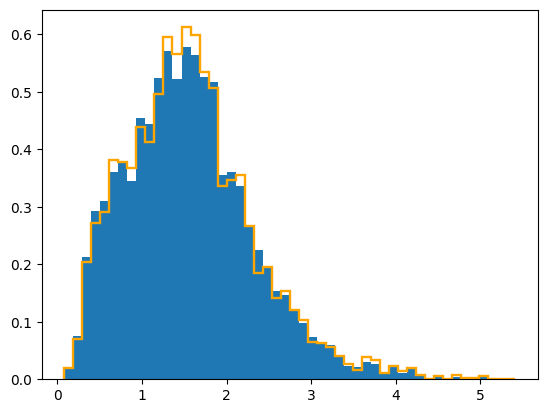

In [8]:
plt.hist(z, nbin, density=True)
plt.hist(xnew, bins=x, density=True, color='orange',  histtype='step', linewidth=1.7) # stesso binning dei dati iniziali, altrimenti sballa
#plt.plot(xplot,y)
plt.show()

2. Option using scipy.stats.rv_histogram(), that creates a step function that represents the profile of the histogram

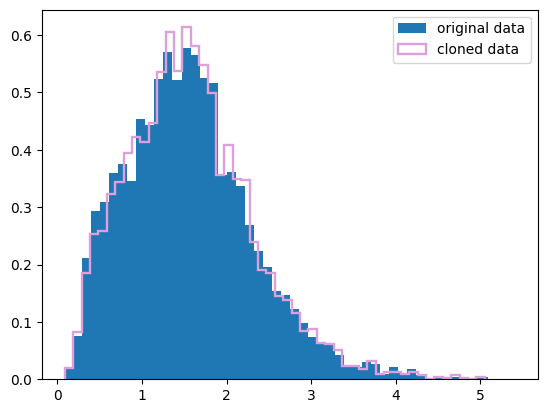

In [9]:
xt = np.random.uniform(xmin-10,xmax+10,Nt)
yt = np.random.uniform(0,ymax,Nt)

sf = scipy.stats.rv_histogram((y,x))
rejection_mask = yt<=sf.pdf(xt)    # assess whether ynew <= sf(xnew)
monte_carlo = xt[rejection_mask]     # reject all points that don't pass, using masking

plt.hist(z,bins=50,density=True,label='original data')
plt.hist(monte_carlo, bins=nbin, density=True, histtype='step', label='cloned data', color='plum', linewidth=1.7)

plt.legend()
plt.show()


3. Even quicker, use the rejection sampling already implemented in scipy

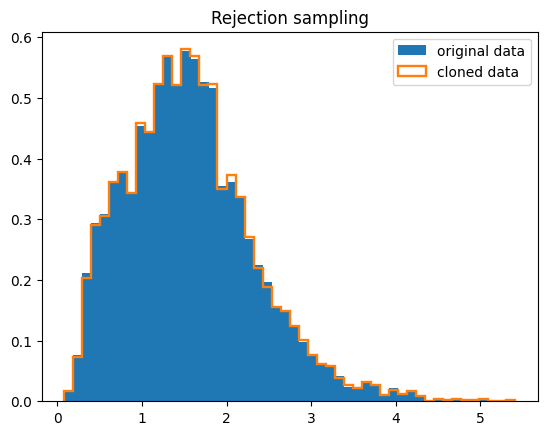

In [10]:
plt.hist(z,bins=50,density=True,label='original data')
plt.hist(sf.rvs(size=Nt), bins=50, density=True, histtype='step', label='cloned data', linewidth=1.7)
plt.title('Rejection sampling')

plt.legend()
plt.show()

## Inverse transform sampling

In [11]:
y, x = np.histogram(z, bins=nbin, density=True)
sf = scipy.stats.rv_histogram((y,x))

In [12]:
x_mids = (x[1:]+x[:-1])/2

pdf = sf.pdf(x_mids)
cdf = sf.cdf(x_mids)

quantile_function = scipy.interpolate.interp1d(cdf, x_mids)  # invert the cdf

In [13]:
x_perc = np.random.uniform(min(cdf),max(cdf), 10000) 
x_new = quantile_function(x_perc)

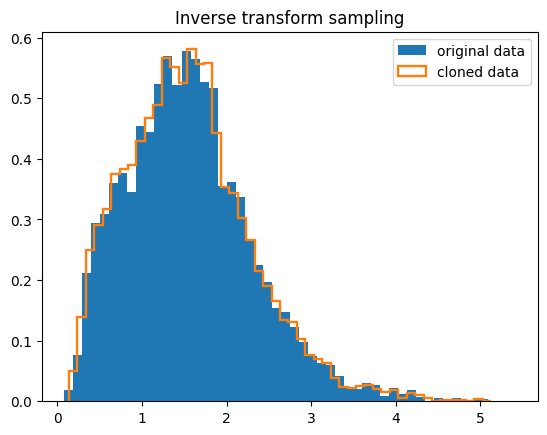

In [14]:
plt.hist(z,bins=50,density=True,label='original data')
plt.hist(x_new, bins=50, density=True, histtype='step',label='cloned data', linewidth=1.7)
plt.title('Inverse transform sampling')

plt.legend()
plt.show()

## Cosmology of quasars

In [15]:
import astropy
astropy.cosmology.Planck18

FlatLambdaCDM(name='Planck18', H0=<Quantity 67.66 km / (Mpc s)>, Om0=0.30966, Tcmb0=<Quantity 2.7255 K>, Neff=3.046, m_nu=<Quantity [0.  , 0.  , 0.06] eV>, Ob0=0.04897)

Let's see how quasars would be distributed as a function of redshift if they were uniformly distributed in comoving volume

In [16]:
z_max = 5
z_grid = np.linspace(0, z_max, 1000)

Find the differential comoving volume

In [17]:
diff_com_vol_grid = 4. * np.pi * astropy.cosmology.Planck18.differential_comoving_volume(z_grid).value  # 4*pi because over all directions

Integrate over all the z to determine the norm needed to normalize the pdf

In [18]:
norm = np.trapz(diff_com_vol_grid, z_grid) 

Compute the normalized pdf

In [19]:
pdf = diff_com_vol_grid/norm

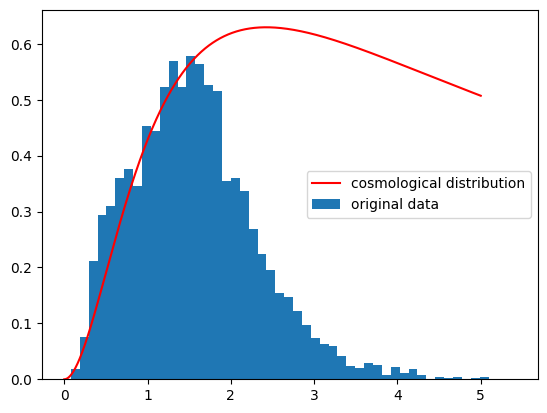

In [20]:
plt.plot(z_grid, 2.5*pdf, color='r',label='cosmological distribution') # adjust the normalization by eye
plt.hist(z,bins=50,density=True,label='original data')     

plt.legend()
plt.show()

So we can see that the observed quaesars are distributed uniformly in comoving volume for lower values of redshift (z < 1.5).
For higher values, there are less than expected. In particular, quasars reach a maximum around z=2, then decreases.

# Why?